# Credit Card Fraud Detection

# Disclaimer

This notebook is part of Alura's course Árvores de Decisão: aprofundando em modelos de Machine Learning (Decision trees: delving into Machine Learning models) by Thainá Mariani ([Link](https://cursos.alura.com.br/course/arvores-decisao-aprofundando-modelos-machine-learning)).

[Here](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) you can find the credit card fraud detection on Kaggle.

All the code was written in Python 3, using Google Colab.

**For more info, check the README.**

In [1]:
# Import libraries

import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier 

from utils.model import run_model, validator_stratified_shuffle_split
from utils.plotting import plot_confusion_matrix
from utils.score import validation_scores

# Downloading the dataset from Kaggle

I will download the dataset using Kaggle's API and store the csv file in a Google Drive folder.

In [3]:
# Set kaggle API credentials

os.environ["KAGGLE_USERNAME"] = "" 
os.environ["KAGGLE_KEY"] = ""

In [48]:
# Download dataset

! kaggle datasets download -d mlg-ulb/creditcardfraud

creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)


In [49]:
# Unzip file

! unzip /content/creditcardfraud.zip

Archive:  /content/creditcardfraud.zip
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: creditcard.csv          


In [50]:
# Importing the data and displaying the first 5 rows

df = pd.read_csv("/content/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# EDA

Let's check for null values.

In [51]:
# Checking for null data

print(df.isna().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


There are no null values. Let's see the statiscal summary of all features.

In [52]:
# Displaying main statistics

df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


We can see that all the features except for "Time", "Amount" and "Class" are normalized since all the data is encrypted. 

Now, let's check for the total number transactions and which ones are fraud and non-fraud.

In [53]:
# Printing the number of frauds and non-frauds

number_transactions = df['Class'].count()
number_frauds = df['Class'].sum()
number_non_frauds = number_transactions - number_frauds

print("Total transactions: ", number_transactions)
print("Number of frauds: ", number_frauds)
print("Number of non-frauds: ", number_non_frauds)

Total transactions:  284807
Number of frauds:  492
Number of non-frauds:  284315


We can see that our dataset is imbalanced due to the low number of fraudulent transactions (0.17%). This will be important later on when we build our model. We are going to guarantee that the test dataset has records classified as a fraud to train our model correctly.

# Building the model

Now we can build our model using the StratifiedShuffleSplit method from sklearn to ensure that we will have fraudulent transactions in our model. Otherwise, may be a risk of, when the code is splitting the data, it ends up with a training set without any fraud which is hazardous to our model. 

In [58]:
# Splitting the data

X = df.drop('Class', axis=1).values
y = df['Class'].values
X_train, X_test, y_train, y_test = validator_stratified_shuffle_split(X, y)

In [59]:
# Running decision tree model

%%time

decision_tree = tree.DecisionTreeClassifier()
y_pred_decision_tree = run_model(decision_tree, X_train, X_test, y_train)

CPU times: user 26.9 s, sys: 49.9 ms, total: 27 s
Wall time: 27 s


Accuracy score:  0.9990519995786665
Precision score:  0.7291666666666666
Recall score:  0.7142857142857143
Confusion matrix, without normalization
[[   35    14]
 [   13 28419]]


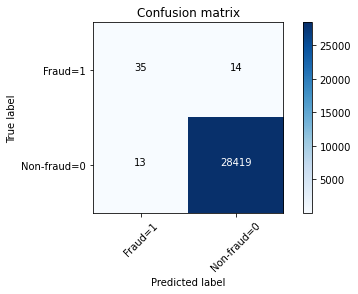

In [60]:
# Displaying the model's score

validation_scores(y_test, y_pred_decision_tree)

# Computing confusion matrix

plot_confusion_matrix(y_test, y_pred_decision_tree)
np.set_printoptions(precision=2)

We can see that our accuracy is high due to the unbalanced data, on the other hand, precision and recall have average scores, around 0.7 each. Looking at the confusion matrix, we see that have 16 false negatives and 14 false positives. 

Since we are dealing with credit card transactions, our model needs enhancement for two reasons:

1. reduce the number of false positives because a lot of clients will be affected and their relationship with the bank could be damaged, leading to loss of clients.

2. reduce the number of false negatives because a lot of fraudulent transactions will be approved and the bank will lose money by having their operation stopped and have a damaged reputation.

So, we need to improve the model's performance. First, let's look at the maximum depth of our tree. Remembering that the deeper our tree is the higher chances of overfitting we will have.  

In [61]:
# Printing max_depth

print(decision_tree.get_depth())

21


Our decision tree has a maximum depth of 21, which is a lot. Let's limit it to 10 to avoid overfitting and see if the model will have a better performance.

In [62]:
# Running DecisionTreeClassifier

%%time

decision_tree_ten = tree.DecisionTreeClassifier(max_depth=10, random_state=0)
y_pred_decision_tree = run_model(decision_tree_ten, X_train, X_test, y_train)

CPU times: user 16.2 s, sys: 22 ms, total: 16.3 s
Wall time: 16.2 s


Accuracy score:  0.9994733330992591
Precision score:  0.9473684210526315
Recall score:  0.7346938775510204
Confusion matrix, without normalization
[[   36    13]
 [    2 28430]]


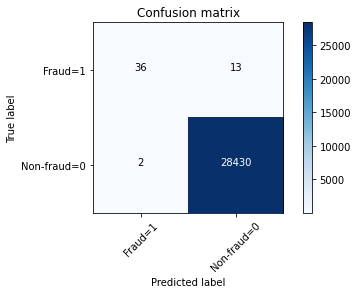

In [63]:
# Displaying the model's score

validation_scores(y_test, y_pred_decision_tree)

# Computing confusion matrix

plot_confusion_matrix(y_test, y_pred_decision_tree)
np.set_printoptions(precision=2)

The precision increased a lot because the model was able to decrease the number of false positives. But the recall score is similar to the previous decision tree. Let's change another decision tree parameter. This time we are going to limit the minimum samples in each leaf to 10, in other words, if any leaf has less than 10 records, there will be no more decisions to take and the tree will not get deeper.

In [64]:
# Rnning DecisionTreeClassifier with limited min_samples_leaf 

%%time

decision_tree_leaf = tree.DecisionTreeClassifier(max_depth=10, random_state=0, min_samples_leaf=10)
y_pred_decision_tree = run_model(decision_tree_leaf, X_train, X_test, y_train)

CPU times: user 16.7 s, sys: 15 ms, total: 16.7 s
Wall time: 16.6 s


Accuracy score:  0.9993679997191109
Precision score:  0.8604651162790697
Recall score:  0.7551020408163265
Confusion matrix, without normalization
[[   37    12]
 [    6 28426]]


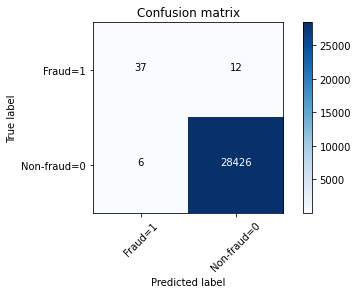

In [65]:
# Displaying the model's score

validation_scores(y_test, y_pred_decision_tree)

# Computing confusion matrix

plot_confusion_matrix(y_test, y_pred_decision_tree)
np.set_printoptions(precision=2)

This time the precision got worse and the recall score changed slightly but in general, this model did not go well. 

Since we limited our tree to the maximum depth of 10 and it got better results. Let's see if a simpler model with a maximum depth of 5 will be better. 

In [78]:
# Rnning DecisionTreeClassifier with max depth of 5

%%time

decision_tree_five= tree.DecisionTreeClassifier(max_depth=5, random_state=0)
y_pred_decision_tree = run_model(decision_tree_five, X_train, X_test, y_train)

CPU times: user 9.84 s, sys: 14 ms, total: 9.85 s
Wall time: 11 s


Accuracy score:  0.999403110845827
Precision score:  0.9210526315789473
Recall score:  0.7142857142857143
Confusion matrix, without normalization
[[   35    14]
 [    3 28429]]


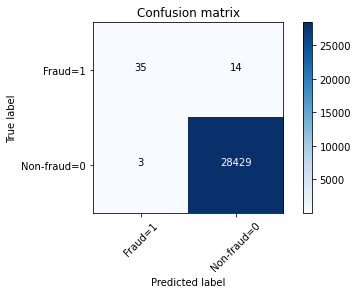

In [79]:
# Displaying the model's score

validation_scores(y_test, y_pred_decision_tree)

# Computing confusion matrix

plot_confusion_matrix(y_test, y_pred_decision_tree)
np.set_printoptions(precision=2)

We can see that the score did not perform better than the decision tree with a maximum depth of 10. Since single decision trees seem to get stuck in terms of score and performance, let's use ensemble learning to improve our models.

# Emsemble learning: bagging

Since our decision tree model has lots of false positives and false negatives, our anti-fraud detection system has its gaps to fill. To enhance the chances of stopping the fraudulent transactions and letting the non-fraudulent ones intact, we will use an ensemble learning technique called bagging i.e. *bootstrapping aggregating*. *Bootstrapping* is a population resampling, in many subsamples, in a way that the main characteristics are maintained and they have to be independent of each other. Then we will create a model using each of these subsamples and then aggregate all the outcomes in one metric (sum, mean, etc). The most well-known bagging algorithm is Random Forest, which I will use from now on.

Randon forest creates several estimators, i.e. simple decision trees, using subsamples of the original data and some, not all, features to train the algorithm. Those records not used in a determined decision tree (out-of-bag data) will be labeled as True or False. After all the algorithms are finished, the outcome of all records will be set as the most "voted" outcome of all algorithms. 

We will also check the running time of all models plus their scores to decide which one is the best.

In [68]:
# Running random forest model for 100 estimators 

%%time

random_forest = RandomForestClassifier(n_estimators=100, random_state=0)
y_pred_random_forest = run_model(random_forest, X_train, X_test, y_train)

CPU times: user 5min 27s, sys: 304 ms, total: 5min 27s
Wall time: 5min 25s


Accuracy score:  0.9995084442259752
Precision score:  0.9487179487179487
Recall score:  0.7551020408163265
Confusion matrix, without normalization
[[   37    12]
 [    2 28430]]


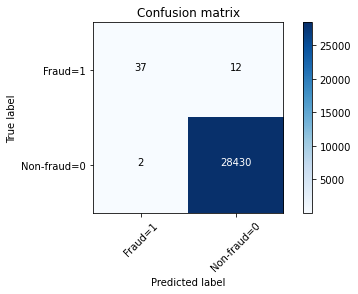

In [69]:
# Displaying the model's score

validation_scores(y_test, y_pred_random_forest)

# Computing confusion matrix

plot_confusion_matrix(y_test, y_pred_random_forest)
np.set_printoptions(precision=2)

The random forest algorithm had a similar performance compared to our maximum-depth-of-10 decision tree but it took a lot more to run. Let's change the number of estimators i.e. number of single decision trees, to 50 and set the max_depth parameter to 10, and see the time to run and the scores.

In [70]:
# Running random forest model for 50 estimators 

%%time

random_forest = RandomForestClassifier(n_estimators=50, random_state=0, max_depth=10)
y_pred_random_forest = run_model(random_forest, X_train, X_test, y_train)

CPU times: user 1min 37s, sys: 112 ms, total: 1min 37s
Wall time: 1min 37s


Accuracy score:  0.9995435553526912
Precision score:  0.9736842105263158
Recall score:  0.7551020408163265
Confusion matrix, without normalization
[[   37    12]
 [    1 28431]]


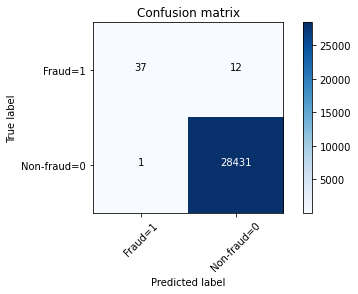

In [71]:
# Displaying the model's score

validation_scores(y_test, y_pred_random_forest)

# Computing confusion matrix

plot_confusion_matrix(y_test, y_pred_random_forest)
np.set_printoptions(precision=2)

This time, the algorithm was two times faster, but only the precision score improved. Let's change our approach for this problem and use another ensemble learning technique, boosting.

# Ensemble learning: boosting

Unlike bagging, boosting technique creates dependent and sequential models. One of the most famous boosting algorithms is AdaBoost, i.e. adaptative boosting. Every following model will correct the mistakes in the previous model and so on. That's why we call it adaptative.  

But how does this AdaBoost work?

1. The algorithm will label every record in our dataset with equal weights (1/total number of records). Then, it builds simple decision trees based on only one dataset feature at a time with all rows.  

2. The algorithm choose randomly a tree and it calculates its influence over the other decision trees using the following formula: $\alpha = \frac{1}{2}log(\frac{1 - error}{error})$, where error is calculated by: $error = \frac{\text{records wrongly labeled}}{\text{all the records}}$. $\alpha$ can assume positive and negative values but the larger the number is the more influence in the following tree our decision tree will have.

3. Change the original weight of every record, using the following formula: $w_{i} = w_{i-1}*e^{\pm \alpha}$, where $w_{i}$ is the new record weight and $w_{i-1}$ is the previous record weight. When the record is wrongly labeled, it uses the + because we need to improve its weight to correct the label in the next iteration. Otherwise, i.e. when the record is correctly labeled, then we use the - because this record is already done and the algorithm needs to focus on the wrong ones. 

4. Set the interval by adding the weight of a record and the following record. Then, the algorithm will pick n random number between 0 and the sum of the last row's weight, creating a new dataset with its original number of rows. This dataset may contain duplicated records. 

5. Set equal weights again in the new dataset and then start the process all over again. 

Now let's instantiate our model. 

In [72]:
# Running AdaBoost model 

%%time

adaboost = AdaBoostClassifier(random_state=0)
y_pred_adaboost = run_model(adaboost, X_train, X_test, y_train)

CPU times: user 1min 36s, sys: 127 ms, total: 1min 36s
Wall time: 1min 36s


Accuracy score:  0.9992626663389628
Precision score:  0.8888888888888888
Recall score:  0.6530612244897959
Confusion matrix, without normalization
[[   32    17]
 [    4 28428]]


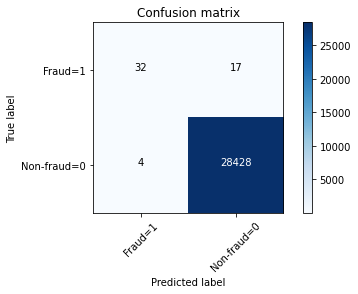

In [73]:
# Displaying the model's score

validation_scores(y_test, y_pred_adaboost)

# Computing confusion matrix

plot_confusion_matrix(y_test, y_pred_adaboost)
np.set_printoptions(precision=2)

Even with adaptative boosting, we did not improve our model. Reading the sklearn documentation, we can see that, by default, the number of estimators is 50. Let's raise this parameter to 100 and see what happens. 

In [74]:
# Running AdaBoost model for 100 estimators

%%time

adaboost = AdaBoostClassifier(random_state=0, n_estimators=100)
y_pred_adaboost = run_model(adaboost, X_train, X_test, y_train)

CPU times: user 3min 8s, sys: 238 ms, total: 3min 9s
Wall time: 3min 8s


Accuracy score:  0.999403110845827
Precision score:  0.8636363636363636
Recall score:  0.7755102040816326
Confusion matrix, without normalization
[[   38    11]
 [    6 28426]]


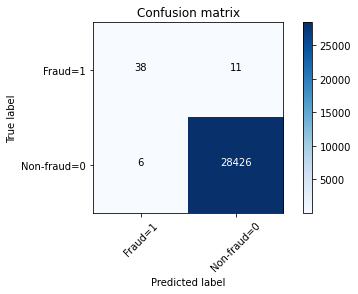

In [75]:
# Displaying the model's score

validation_scores(y_test, y_pred_adaboost)

# Computing confusion matrix

plot_confusion_matrix(y_test, y_pred_adaboost)
np.set_printoptions(precision=2)

Only the recall score improved, and the precision got stuck. Let's increase even more the number of estimators to 200.

In [76]:
# Running AdaBoost model for 200 estimators

%%time

adaboost = AdaBoostClassifier(random_state=0, n_estimators=200)
y_pred_adaboost = run_model(adaboost, X_train, X_test, y_train)

CPU times: user 6min 16s, sys: 486 ms, total: 6min 17s
Wall time: 6min 15s


Accuracy score:  0.9995435553526912
Precision score:  0.9285714285714286
Recall score:  0.7959183673469388
Confusion matrix, without normalization
[[   39    10]
 [    3 28429]]


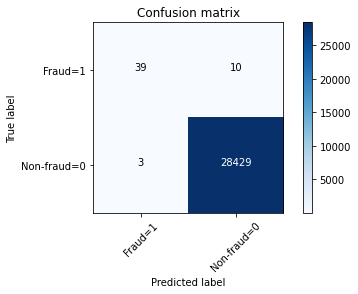

In [77]:
# Displaying the model's score

validation_scores(y_test, y_pred_adaboost)

# Computing confusion matrix

plot_confusion_matrix(y_test, y_pred_adaboost)
np.set_printoptions(precision=2)

# Score compilation

|MODEL|PRECISION|RECALL|FALSE NEGATIVES|FALSE POSITIVES|TIME (s)|
|-----|---------|------|---------------|---------------|----|
|Decision tree|0.729|0.714|14|13|27.0|
|Decision tree max depth of 10|0.947|0.735|13|2|16.3|
|Decision tree min samples leaf of 10|0.861|0.755|12|6|16.7|
|Decision tree max depth of 5|0.921|0.714|14|3|9.5|
|Random forest|0.949|0.755|12|2|327.0|
|Random forest 50 estimators & max depth of 10|0.974|0.755|12|1|97.0|
|AdaBoost 50 estimators|0.888|0.653|17|4|96.0|
|AdaBoost 100 estimators|0.864|0.776|11|6|189.0|
|AdaBoost 200 estimators|0.929|0.780|10|3|377.0|

We can see that 2 out of 9 models were the best in terms of score: **random forest with 50 estimators & max depth of 10** and **AdaBoost with 200 estimators**. But the latter took approximately 4 times to run and since it is using lots of estimators, its good results are probably due to overfitting, which is not good. Recalling that our dataset has a couple of hundred thousand records, which is an infamous part of the total credit card transactions per day. In other words, this model is not scalable. So, the best model including time-consuming parameters is the former one.

# Recommendations

It is impossible to build a model that can detect which transactions are fraudulent or not. And our random forest algorithm had a few false positives and false negatives remaining, more the latter than the former one.

Adopting this model as the default one to prevent and detect credit card fraud, the company will expect some cardholders' phone calls asking why their transactions could not be approved. This could lead to loss of clients (and revenue) and somewhat reputation damage. In case of undetected frauds, we could draw some action plans such as:

  i) reimbursed them as fast as possible, to repair the client's eventual monetary damage;
  
  ii) give discounts on future credit card purchases;

  iii) ensure that the company has active plans to increase credit card transaction security.